# Simple random price generator

In this file we generate random asset price time series by balancing randomly generated supply and demand curves and searching for their intersection. We will consider a society of buyers and sellers, where each buyer submits a bid price for one unit of asset, and each seller submits a sell price for one unit of asset. The prices are drawn from gaussian distribution with the specified means and standard deviations. The means and standard deviations are the time series, and so are the numbers of buyers $N$ and sellers $M$. The dynamics of the system is considered in discrete time $t$, over $T$ steps.

At each time step the price $P$ of the asset is determined by equilibrating supply and demand, which in continuous approximation looks like

\begin{equation}
N\,\int _{P_*}^\infty dp\,f_b(p)=M\,\int_{0}^{P_*}dp\,f_a(p)\,,
\end{equation}

where $f_{b,a}$ are bid/ask distributions at that time.

In the discrete realization we sort all the submitted sell orders in increasing order, and all the submitted buy orders in decreasing order. Since each of the traders submits an order for strictly one unit of asset, we can start matching the orders by simply crossing out pairs of bids and asks, while the bid price is not less than the ask price.

In [1]:

import numpy as np
import matplotlib.pyplot as plt

class Simulation:
    
    def __init__(self,T,N,M,bid_mean,bid_sd,ask_mean,ask_sd,initial_price):
        '''
        Attributes:
            
            T -- Number of simulation steps.
            
            N -- Number of buyers. List of length T.
            
            M -- Number of sellers. List of length T.
            
            bid_mean, bid_sd -- Parameters of the normal buy draw.
                                List of length T.
            
            ask_mean, ask_sd -- Parameters of the normal sell draw.
                                List of length T.
            
            bids -- Submitted bids at the given time step.
            
            asks -- Submitted asks at the given time step.
            
            initial_price -- Initial price.
            
            prices -- Emergent price series.
            
            volumes -- Emergent volume series.
        '''
        self.T=T       
        self.N=N
        self.M=M
        self.bid_mean=bid_mean
        self.bid_sd=bid_sd
        self.ask_mean=ask_mean
        self.ask_sd=ask_sd
        self.bids=[]
        self.asks=[]
        self.initial_price=initial_price
        self.prices=[initial_price]
        self.volumes=[]

    def enter_buyers(self,t):
        '''
        Enter random bids and sort them
        '''
        for a in range(self.N[t]):
            self.bids+=[np.random.normal(self.bid_mean[t],self.bid_sd[t])]
        self.bids.sort(reverse=True)
        
    def enter_sellers(self,t):
        '''
        Enter random asks and sort them
        '''
        for a in range(self.M[t]):
            self.asks+=[np.random.normal(self.ask_mean[t],self.ask_sd[t])]
        self.asks.sort()
        
    def find_intersection(self,t):
        '''
        Determine intersection price and volume. Return tuple
        price, volume. If no intersection return -1,0.
        
        Works by crossing out pairs from the largest bids and
        smallest asks. The optimal price is 'met in the middle'
        and updated each time we can cross out a pair if a 
        buyer and seller. The last optimal price will be the new
        price.
        '''
        i,j=0,0
        vol=0
        price=-1
        while i<self.N[t] and j<self.M[t]:
            if self.bids[i]<self.asks[j]:
                break
            elif self.bids[i]==self.asks[j]:
                vol+=1
                price=self.bids[i]
                break
            elif self.bids[i]>self.asks[j]:
                vol+=1
                price=(self.bids[i]+self.asks[j])/2.0
                i+=1
                j+=1
        return price, vol
        
    def run(self):
        '''
        Run T rounds of simulation. Clean the buy and sell
        books before each round.
        '''
        for t in range(self.T):
            self.bids=[]
            self.asks=[]
            self.enter_buyers(t)
            self.enter_sellers(t)
            price,vol=self.find_intersection(t)
            if price==-1:
                self.prices+=[self.prices[-1]]
                self.volumes+=[0]
            else:
                self.prices+=[price]
                self.volumes+=[vol]

Specify the parameters, and instantiate a simulation object with those parameters. We chose an exponentially inflating submitted price means for this example.

In [2]:
T=100
N=[500]*T
M=[900]*T
initial_price=100
bid_mean=[]
bid_sd=[]
ask_mean=[]
ask_sd=[]

for t in range(T):
    bid_mean+=[np.random.normal(100*np.exp(0.002*t),2)]
    bid_sd+=[abs(np.random.normal(2,1))]
    ask_mean+=[np.random.normal(100*np.exp(0.002*t),2)]
    ask_sd+=[abs(np.random.normal(2,1))]
    
simulation=Simulation(T,N,M,bid_mean,bid_sd,ask_mean,ask_sd,initial_price)

As a first example, let's generate bids and asks once, and plot the corresponding supply and demand curves. We can then ask the find_intersection() method to determine precisely what is the intersection price and volume, and compare it with what we see in the plot.

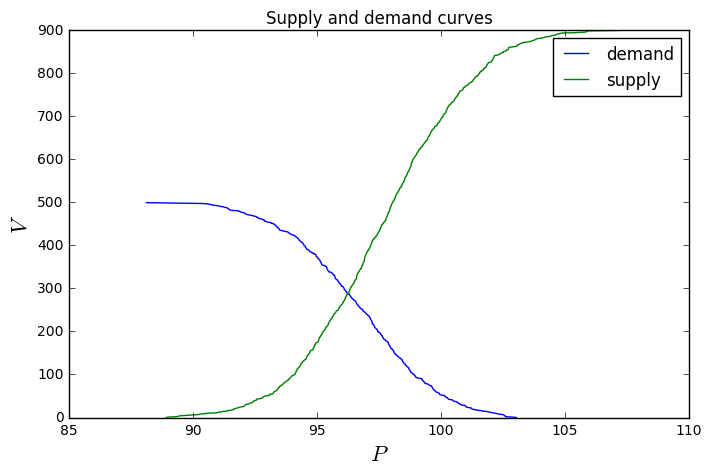

Intersection Price=96.25, Volume=288


In [3]:
simulation.bids=[]
simulation.asks=[]
simulation.enter_buyers(0)
simulation.enter_sellers(0)
M_count=[i for i in range(M[0])]
N_count=[i for i in range(N[0])]
supplu_and_demand_plot=plt.figure(figsize=(8,5),dpi=400)
plt.plot(simulation.bids,N_count,label='demand')
plt.plot(simulation.asks,M_count,label='supply')
plt.title("Supply and demand curves",rasterized=False)
plt.xlabel("$P$",fontsize=16, color='black', rasterized=False)
plt.ylabel("$V$",fontsize=16, color='black', rasterized=False)
plt.legend()
plt.show()
intersection=simulation.find_intersection(0)
print "Intersection Price={}, Volume={}".format(int(intersection[0]*100)/100.0,intersection[1])

Now let's run the simulation multiple times and plot the emergent price and volume time series.

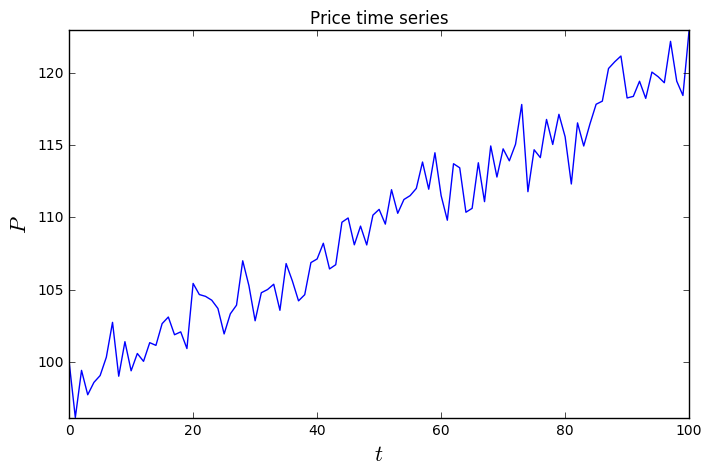

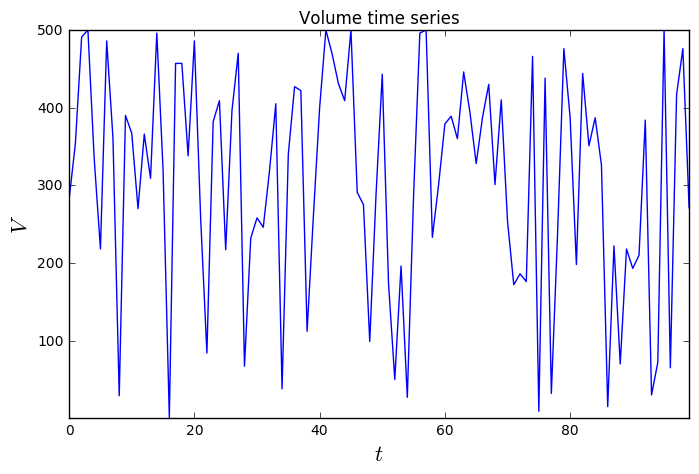

In [4]:
simulation.run()

prices_plot=plt.figure(figsize=(8,5),dpi=400)
plt.plot(np.arange(T+1),simulation.prices,rasterized=True)
plt.title("Price time series",rasterized=False)
plt.xlabel("$t$",fontsize=16, color='black', rasterized=False)
plt.ylabel("$P$",fontsize=16, color='black', rasterized=False)
plt.axis('tight')
plt.show()

volume_plot=plt.figure(figsize=(8,5),dpi=400)
plt.plot(np.arange(T),simulation.volumes,rasterized=True)
plt.title("Volume time series",rasterized=False)
plt.xlabel("$t$",fontsize=16, color='black', rasterized=False)
plt.ylabel("$V$",fontsize=16, color='black', rasterized=False)
plt.axis('tight')
plt.show()